In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

import sys
sys.path.append('..')

from datetime import datetime

import pyarrow.compute as pc
import numpy as np
import pandas as pd

import brasa

In [3]:
symbols = [
    "ABEV3",
    "ARZZ3",
    "B3SA3",
    "BBAS3",
    "EGIE3",
    "EZTC3",
    "INTB3",
    "ITSA4",
    "PSSA3",
    "WEGE3",
]

rets = brasa.get_returns(symbols=symbols, start=datetime(2024, 1, 1), end=datetime.today())

In [4]:
rets.sum().sort_values()

EZTC3   -0.358483
B3SA3   -0.291044
ARZZ3   -0.266971
ABEV3   -0.172395
ITSA4   -0.026800
EGIE3   -0.015798
BBAS3   -0.002292
WEGE3    0.027501
PSSA3    0.065765
INTB3    0.072370
dtype: float64

In [5]:
weights = pd.Series([
    9.58/100,
    10.75/100,
    7.80/100,
    11.71/100,
    19.17/100,
    8.00/100,
    5.84/100,
    9.55/100,
    15.62/100,
    1.96/100,
], index=symbols)
weights

ABEV3    0.0958
ARZZ3    0.1075
B3SA3    0.0780
BBAS3    0.1171
EGIE3    0.1917
EZTC3    0.0800
INTB3    0.0584
ITSA4    0.0955
PSSA3    0.1562
WEGE3    0.0196
dtype: float64

In [6]:
brasa.describe("b3-companies-cash-dividends")

approved_on: datetime
last_date_prior_ex: datetime
value_cash: float64
ratio: int64
corporate_action_label: unicode
refdate: datetime
payment_date: datetime
symbol: unicode


In [6]:
brasa.show("b3-companies-cash-dividends")

,approved_on,last_date_prior_ex,value_cash,ratio,corporate_action_label,refdate,payment_date,symbol
0,2019-04-24 00:00:00,2019-04-25 00:00:00,0.08,1,DIVIDENDO,2024-01-17,NaT,AALR3
1,2020-04-27 00:00:00,2020-04-27 00:00:00,0.09,1,DIVIDENDO,2024-01-17,2020-12-18 00:00:00,AALR3
2,2007-12-20 00:00:00,2007-12-20 00:00:00,0.32,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
3,2008-03-31 00:00:00,2008-03-31 00:00:00,0.12,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
4,2008-06-30 00:00:00,2008-06-30 00:00:00,0.12,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
5,2008-09-30 00:00:00,2008-09-30 00:00:00,0.13,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
6,2008-12-30 00:00:00,2008-12-30 00:00:00,0.13,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
7,2009-03-31 00:00:00,2009-03-31 00:00:00,0.13,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
8,2009-06-30 00:00:00,2009-06-30 00:00:00,0.13,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2
9,2009-09-30 00:00:00,2009-09-30 00:00:00,0.12,1,JRS CAP PROPRIO,2024-01-17,NaT,ABCB2


In [7]:
df_dvd = brasa.get_dataset("b3-companies-cash-dividends")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("last_date_prior_ex") >= datetime(2023, 1, 1))\
    .to_table()\
    .group_by(["last_date_prior_ex", "symbol", "corporate_action_label"])\
    .aggregate([("value_cash", "sum")])\
    .to_pandas().rename(columns={"last_date_prior_ex": "refdate"}).set_index(["refdate", "symbol"])
df_cl = brasa.get_dataset("b3-cotahist")\
    .filter(pc.field("symbol").isin(symbols))\
    .filter(pc.field("refdate") >= datetime(2023, 1, 1))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas().set_index(["refdate", "symbol"])
df_dvd["dvd_adj"] = df_dvd["value_cash_sum"].where(df_dvd["corporate_action_label"] != "DIVIDENDOS", df_dvd["value_cash_sum"] * 0.85)
df_dvd = df_dvd.groupby(["symbol", "refdate"])["dvd_adj"].sum().reset_index().set_index(["refdate", "symbol"])
df_dvd = df_dvd.join(df_cl, how="left").reset_index()
df_dvd["dvd"] = df_dvd["dvd_adj"]/df_dvd["close"]
df_dvd.groupby("symbol")["dvd"].sum().to_clipboard()
df_dvd

,refdate,symbol,dvd_adj,close,dvd
0,2023-12-19,ABEV3,0.730200,14.70,0.049673
1,2023-06-30,ARZZ3,0.849770,79.07,0.010747
2,2023-11-10,ARZZ3,1.082697,59.03,0.018341
3,2023-02-23,B3SA3,0.036728,10.78,0.003407
4,2023-03-28,B3SA3,0.060230,10.68,0.005639
5,2023-06-27,B3SA3,0.115354,14.06,0.008204
6,2023-09-21,B3SA3,0.105710,12.59,0.008396
7,2023-12-28,B3SA3,0.100519,14.55,0.006909
8,2023-02-23,BBAS3,0.826881,42.10,0.019641
9,2023-03-13,BBAS3,0.352037,38.15,0.009228


In [8]:
brasa.get_dataset("b3-indexes-returns").scanner(columns=["symbol"]).to_table().to_pandas().drop_duplicates()["symbol"].sort_values()

36124    AGFS
16       BDRX
33782    GPTW
19       IBOV
4        IBRA
45496    IBSD
15       IBXL
2        IBXX
23       ICO2
3        ICON
9        IDIV
45764    IDVR
18       IEEX
28393    IFIL
0        IFIX
11       IFNC
8        IGCT
12       IGCX
13       IGNM
22       IMAT
17       IMOB
5        INDX
10       ISEE
7        ITAG
1        IVBX
20       MLCX
6        SMLL
14       TFIX
21       UTIL
Name: symbol, dtype: object

In [9]:
brasa.get_returns(symbols=["IBOV", "AGFS", "IFNC", "ICON", "ICO2", "IEEX", "IFIX", "IFIL", "IMAT", "IDIV", "SMLL", "MLCX", "IMOB", "UTIL", "IVBX", "INDX"],
                  start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values()

IMAT   -0.012361
ICON    0.024384
INDX    0.060341
AGFS    0.082442
SMLL    0.103583
IVBX    0.122868
IFIL    0.147104
IFIX    0.147939
IBOV    0.165400
IEEX    0.166320
MLCX    0.168506
UTIL    0.183209
ICO2    0.188935
IDIV    0.200328
IFNC    0.266738
IMOB    0.345908
dtype: float64

In [10]:
brasa.get_returns(symbols=["HASH11", "QBTC11"], start=datetime(2023, 1, 1), end=datetime.today()).sum()

HASH11    0.808331
QBTC11    1.001696
dtype: float64

<Axes: >

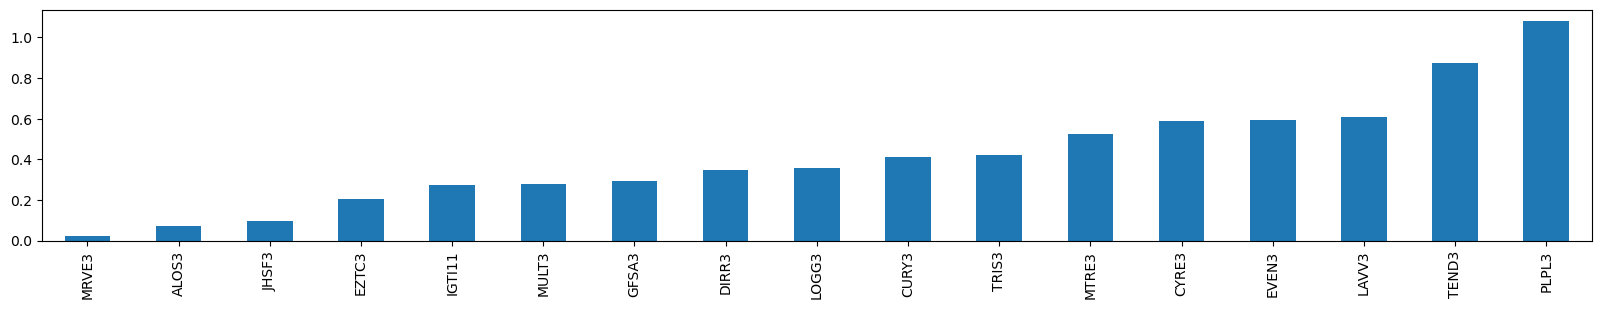

In [11]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IMOB").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

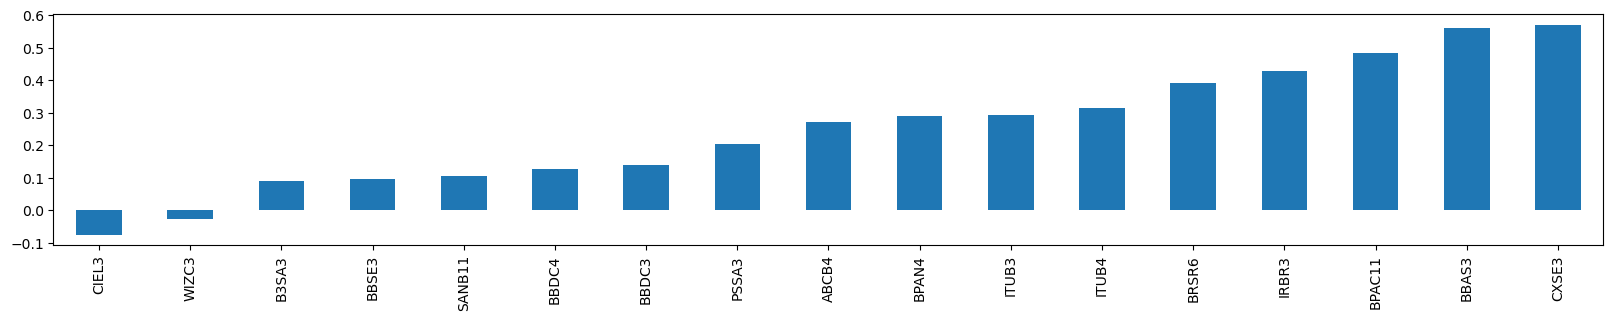

In [12]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IFNC").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

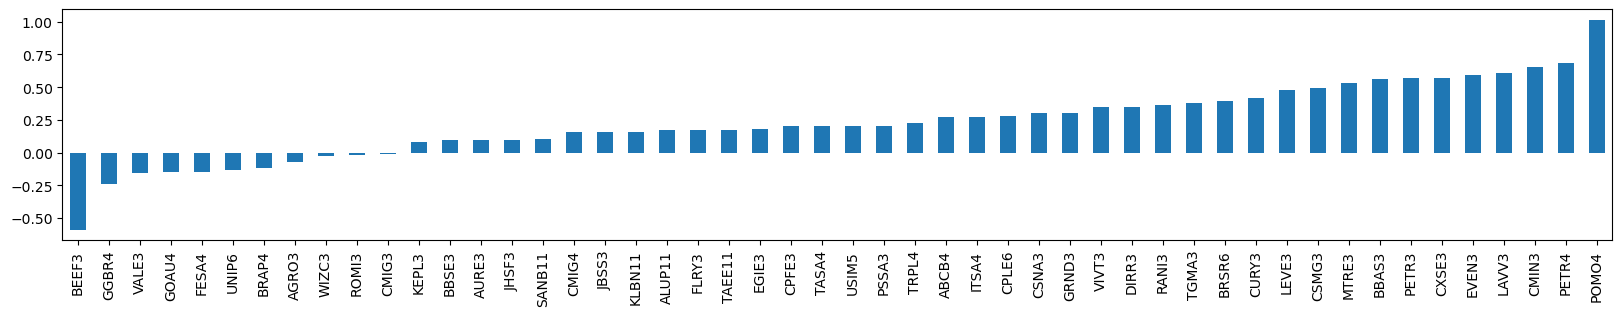

In [13]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "IDIV").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))

<Axes: >

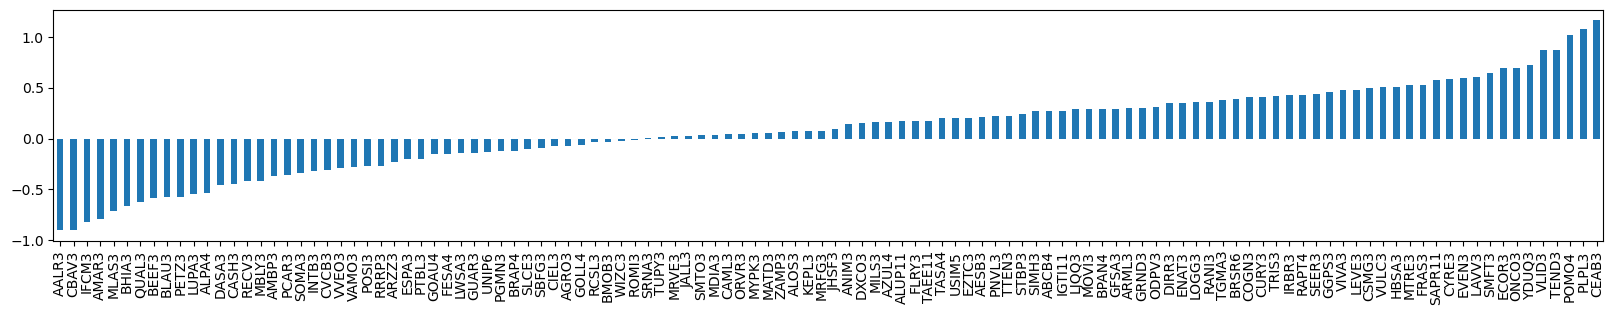

In [14]:
import pyarrow.compute as pc

imob_symbols = brasa.get_dataset("b3-indexes-composition").filter(pc.field("indexes") == "SMLL").to_table().to_pandas()["code"]
brasa.get_returns(symbols=imob_symbols, start=datetime(2023, 1, 1), end=datetime.today()).sum().sort_values().plot(kind="bar", figsize=(20, 3))